In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pprint

Pretty printing has been turned OFF


In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import sys

In [4]:
sys.path.append('../codes')

In [68]:
from VMSfunctions.VMS import *
from VMSfunctions.Common import Peak, NoisyPeak

# Generate Fake Peaks

In [6]:
from VMSfunctions.Common import load_obj
from VMSfunctions.DataGenerator import PeakSampler
from VMSfunctions.ChineseRestaurantProcess import *

In [7]:
m = Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p')

# Basic Scanning Methods

In [8]:
test1_result_basic = []
test2_result_basic = []
test3_result_basic = []
test4_result_basic = []
test5_result_basic = []
test6_result_basic = []

for i in range(0,100):
    Data_test1=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',10,1)
    Data_test2=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',50,1)
    Data_test3=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',100,1)
    test1=Dia_Methods(Data_test1,2,0,"basic","even",num_windows=10)
    test2=Dia_Methods(Data_test1,2,0,"basic","percentile",num_windows=10)
    test3=Dia_Methods(Data_test2,2,0,"basic","even",num_windows=10)
    test4=Dia_Methods(Data_test2,2,0,"basic","percentile",num_windows=10)
    test5=Dia_Methods(Data_test3,2,0,"basic","even",num_windows=10)
    test6=Dia_Methods(Data_test3,2,0,"basic","percentile",num_windows=10)
    test1_result_basic.append(Entropy(Dia_Location_Finder(Scan_Results_Calculator(test1))).entropy)
    test2_result_basic.append(Entropy(Dia_Location_Finder(Scan_Results_Calculator(test2))).entropy)
    test3_result_basic.append(Entropy(Dia_Location_Finder(Scan_Results_Calculator(test3))).entropy)
    test4_result_basic.append(Entropy(Dia_Location_Finder(Scan_Results_Calculator(test4))).entropy)
    test5_result_basic.append(Entropy(Dia_Location_Finder(Scan_Results_Calculator(test5))).entropy)
    test6_result_basic.append(Entropy(Dia_Location_Finder(Scan_Results_Calculator(test6))).entropy)
    
test_result_basic = [test1_result_basic,test2_result_basic,test3_result_basic,test4_result_basic,test5_result_basic,test6_result_basic]

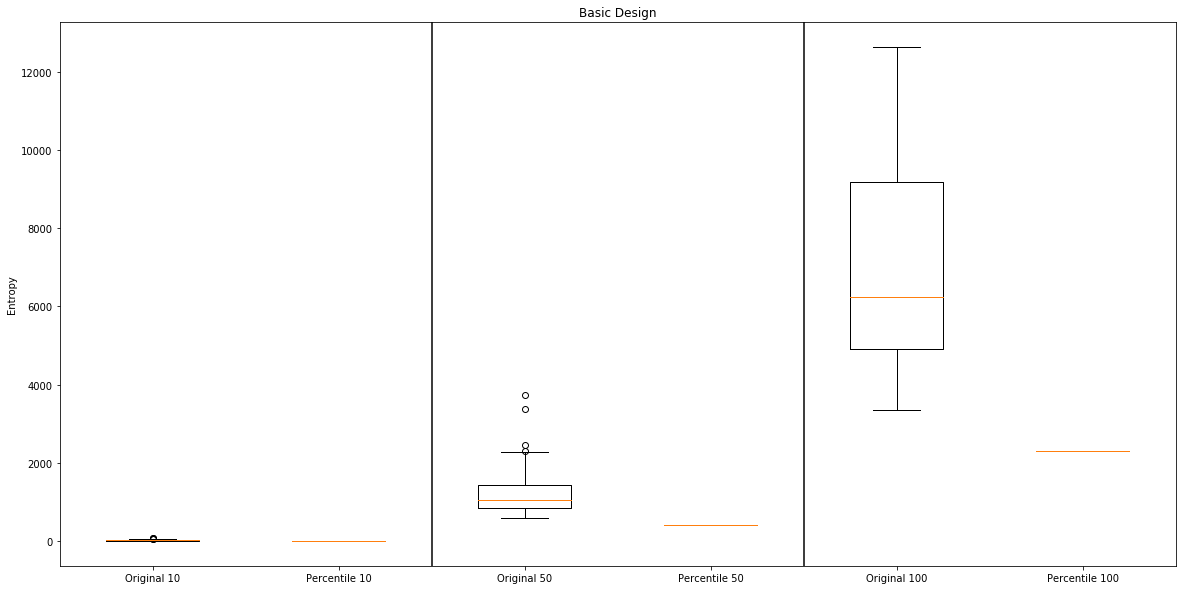

In [9]:
plt.figure(figsize=(20,10))
plt.axvline(x=2.5,color='k')
plt.axvline(x=4.5,color='k')
plt.boxplot(test_result_basic)
plt.ylabel("Entropy")
plt.title("Basic Design")
plt.xticks([1,2,3,4,5,6],["Original 10","Percentile 10","Original 50","Percentile 50","Original 100","Percentile 100"])
plt.show()

# Kaufmann Tree Scanning Method

In [10]:
test1_result_tree = []
test2_result_tree = []
test3_result_tree = []
test4_result_tree = []
test5_result_tree = []
test6_result_tree = []

for i in range(0,100):
    Data_test1=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',10,1)
    Data_test2=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',50,1)
    Data_test3=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',100,1)
    test1=Dia_Methods(Data_test1,2,0,"kaufmann","even","tree")
    test2=Dia_Methods(Data_test1,2,0,"kaufmann","percentile","tree")
    test3=Dia_Methods(Data_test2,2,0,"kaufmann","even","tree")
    test4=Dia_Methods(Data_test2,2,0,"kaufmann","percentile","tree")
    test5=Dia_Methods(Data_test3,2,0,"kaufmann","even","tree")
    test6=Dia_Methods(Data_test3,2,0,"kaufmann","percentile","tree")
    test1_result_tree.append(Entropy(Dia_Location_Finder(Scan_Results_Calculator(test1))).entropy)
    test2_result_tree.append(Entropy(Dia_Location_Finder(Scan_Results_Calculator(test2))).entropy)
    test3_result_tree.append(Entropy(Dia_Location_Finder(Scan_Results_Calculator(test3))).entropy)
    test4_result_tree.append(Entropy(Dia_Location_Finder(Scan_Results_Calculator(test4))).entropy)
    test5_result_tree.append(Entropy(Dia_Location_Finder(Scan_Results_Calculator(test5))).entropy)
    test6_result_tree.append(Entropy(Dia_Location_Finder(Scan_Results_Calculator(test6))).entropy)
    
test_result_tree = [test1_result_tree,test2_result_tree,test3_result_tree,test4_result_tree,test5_result_tree,test6_result_tree]

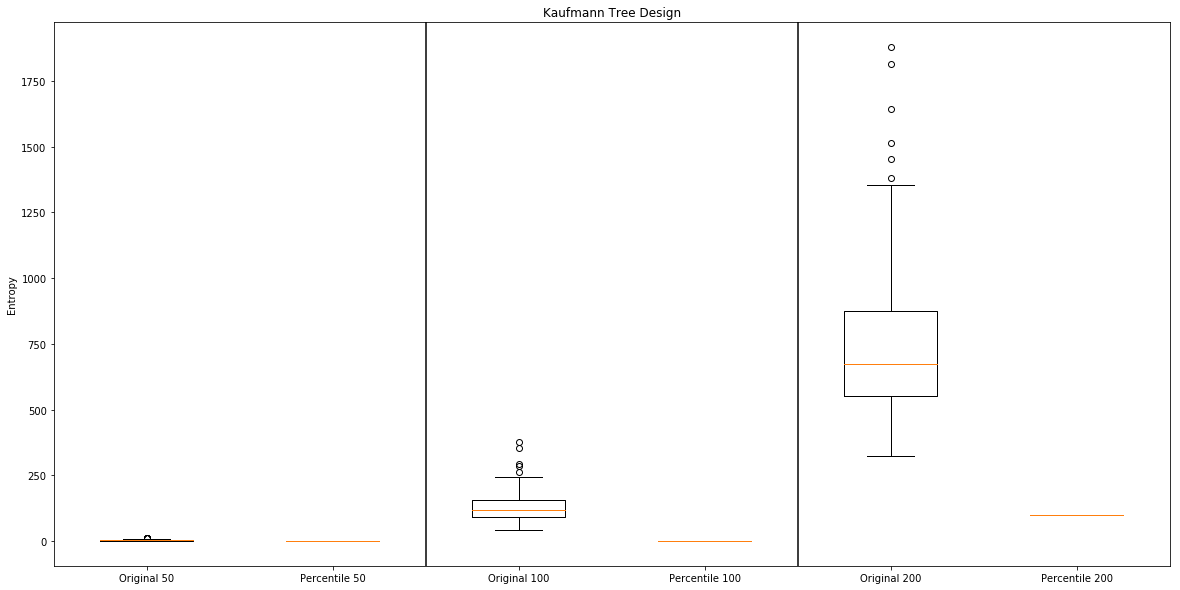

In [11]:
plt.figure(figsize=(20,10))
plt.axvline(x=2.5,color='k')
plt.axvline(x=4.5,color='k')
plt.boxplot(test_result_tree)
plt.ylabel("Entropy")
plt.title("Kaufmann Tree Design")
plt.xticks([1,2,3,4,5,6],["Original 50","Percentile 50","Original 100","Percentile 100","Original 200","Percentile 200"])
plt.show()

# Kaufmann Nested Scanning Method

In [12]:
test1_result_nested = []
test2_result_nested = []
test3_result_nested = []
test4_result_nested = []
test5_result_nested = []
test6_result_nested = []

for i in range(0,100):
    Data_test1=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',10,1)
    Data_test2=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',50,1)
    Data_test3=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',100,1)
    test1=Dia_Methods(Data_test1,2,0,"kaufmann","even","tree")
    test2=Dia_Methods(Data_test1,2,0,"kaufmann","percentile","tree")
    test3=Dia_Methods(Data_test2,2,0,"kaufmann","even","tree")
    test4=Dia_Methods(Data_test2,2,0,"kaufmann","percentile","tree")
    test5=Dia_Methods(Data_test3,2,0,"kaufmann","even","tree")
    test6=Dia_Methods(Data_test3,2,0,"kaufmann","percentile","tree")
    test1_result_nested.append(Entropy(Dia_Location_Finder(Scan_Results_Calculator(test1))).entropy)
    test2_result_nested.append(Entropy(Dia_Location_Finder(Scan_Results_Calculator(test2))).entropy)
    test3_result_nested.append(Entropy(Dia_Location_Finder(Scan_Results_Calculator(test3))).entropy)
    test4_result_nested.append(Entropy(Dia_Location_Finder(Scan_Results_Calculator(test4))).entropy)
    test5_result_nested.append(Entropy(Dia_Location_Finder(Scan_Results_Calculator(test5))).entropy)
    test6_result_nested.append(Entropy(Dia_Location_Finder(Scan_Results_Calculator(test6))).entropy)
    
test_result_nested = [test1_result_nested,test2_result_nested,test3_result_nested,test4_result_nested,test5_result_nested,test6_result_nested]

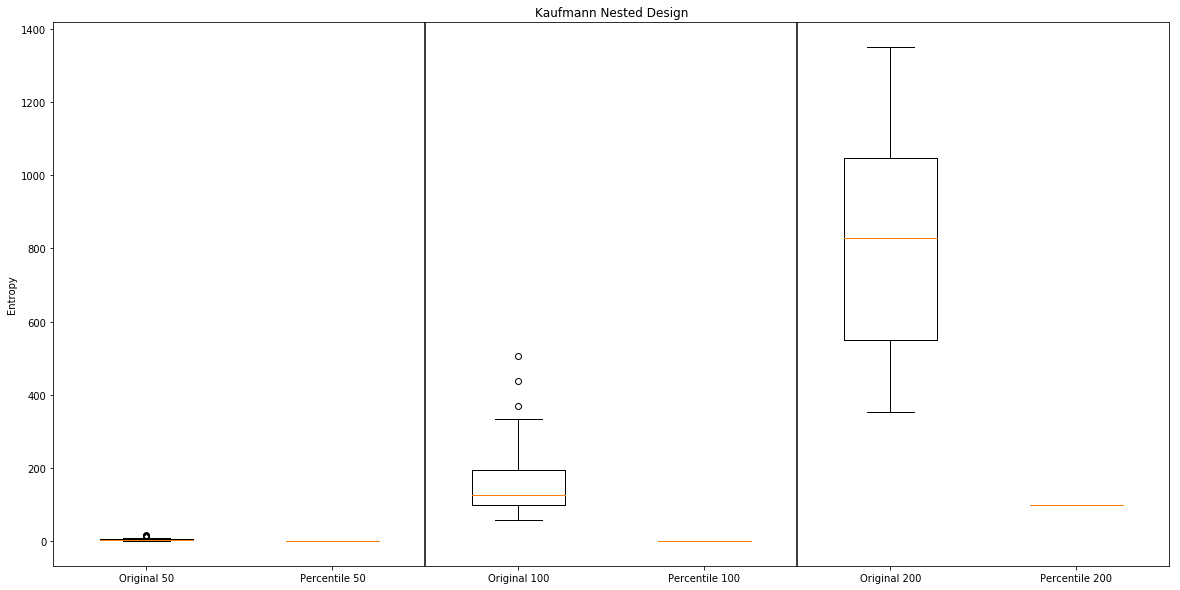

In [13]:
plt.figure(figsize=(20,10))
plt.axvline(x=2.5,color='k')
plt.axvline(x=4.5,color='k')
plt.boxplot(test_result_nested)
plt.ylabel("Entropy")
plt.title("Kaufmann Nested Design")
plt.xticks([1,2,3,4,5,6],["Original 50","Percentile 50","Original 100","Percentile 100","Original 200","Percentile 200"])
plt.show()

# Kaufmann Tree Method Comparisons

[<matplotlib.lines.Line2D object at 0x0000013AF1016CC0>, <matplotlib.lines.Line2D object at 0x0000013AF1016E10>]

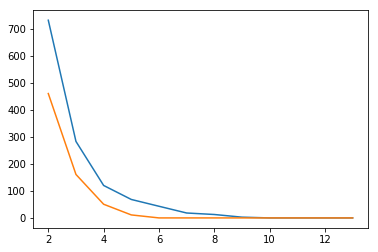

In [72]:
Data_test=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',20,1)
num_extra_bins=7
entropy1 = Entropy_List(Data_test,2,0,"kaufmann","even","tree",extra_bins=num_extra_bins)
entropy2 = Entropy_List(Data_test,2,0,"kaufmann","percentile","tree",extra_bins=num_extra_bins)
plt.plot(range(entropy1.start_subsample_scans,entropy1.end_subsample_scans), entropy1.entropy,range(entropy2.start_subsample_scans,entropy2.end_subsample_scans), entropy2.entropy)

[<matplotlib.lines.Line2D object at 0x0000013AF0BDE518>, <matplotlib.lines.Line2D object at 0x0000013AF0BDE668>]

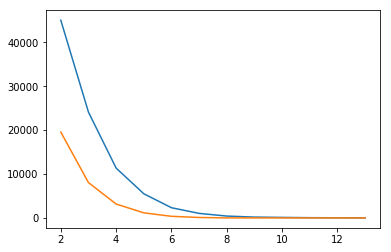

In [71]:
Data_test=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',100,1)
num_extra_bins=7
entropy1 = Entropy_List(Data_test,2,0,"kaufmann","even","tree",extra_bins=num_extra_bins)
entropy2 = Entropy_List(Data_test,2,0,"kaufmann","percentile","tree",extra_bins=num_extra_bins)
plt.plot(range(entropy1.start_subsample_scans,entropy1.end_subsample_scans), entropy1.entropy,range(entropy2.start_subsample_scans,entropy2.end_subsample_scans), entropy2.entropy)

[<matplotlib.lines.Line2D object at 0x0000013AF1085588>, <matplotlib.lines.Line2D object at 0x0000013AF10856D8>]

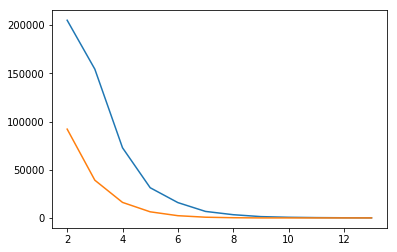

In [70]:
Data_test=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',200,1)
num_extra_bins=7
entropy1 = Entropy_List(Data_test,2,0,"kaufmann","even","tree",extra_bins=num_extra_bins)
entropy2 = Entropy_List(Data_test,2,0,"kaufmann","percentile","tree",extra_bins=num_extra_bins)
plt.plot(range(entropy1.start_subsample_scans,entropy1.end_subsample_scans), entropy1.entropy,range(entropy2.start_subsample_scans,entropy2.end_subsample_scans), entropy2.entropy)

# Multiple MS2 to MS1 observations

In [45]:
Data_test=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p')
num_extra_bins=5

In [46]:
entropy1 = Entropy_List(Data_test,2,0,"kaufmann","even","tree",extra_bins=num_extra_bins)
entropy2 = Entropy_List(Data_test,2,0,"kaufmann","percentile","tree",extra_bins=num_extra_bins)

[<matplotlib.lines.Line2D object at 0x000001E852095748>, <matplotlib.lines.Line2D object at 0x000001E852095550>]

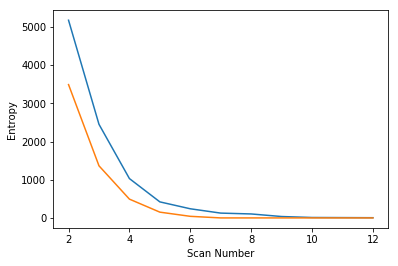

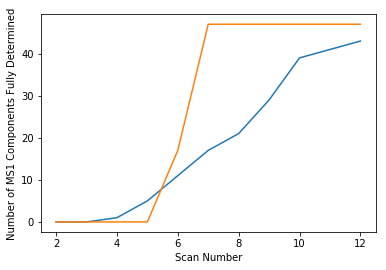

In [19]:
plt.figure(0)
plt.xlabel('Scan Number')
plt.ylabel('Entropy')
plt.plot(range(2,8+num_extra_bins), entropy1,range(2,8+num_extra_bins), entropy2)
plt.figure(1)
plt.xlabel('Scan Number')
plt.ylabel('Number of MS1 Components Fully Determined')
plt.plot(range(2,8+num_extra_bins), ent1[1][2:],range(2,8+num_extra_bins), ent2[1][2:])

Note : Bin walls doesnt seem to come out correctly, but entropy still works

In [20]:
num_extra_bins=5
test3=Dia_Kaufmann(Data_test3,64,"even","nested",extra_bins=num_extra_bins)
test4=Dia_Kaufmann(Data_test3,64,"percentile","nested",extra_bins=num_extra_bins)

In [21]:
ent3 = test3.entropy(8)
ent4 = test4.entropy(8)

[<matplotlib.lines.Line2D object at 0x000001E851C3F470>, <matplotlib.lines.Line2D object at 0x000001E851C3F978>]

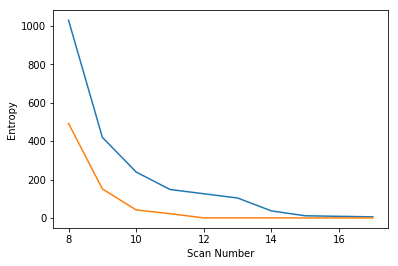

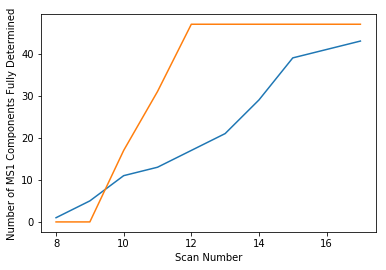

In [22]:
plt.figure(0)
plt.xlabel('Scan Number')
plt.ylabel('Entropy')
plt.plot(range(8,13+num_extra_bins), ent3[0][8:],range(8,13+num_extra_bins), ent4[0][8:])
plt.figure(1)
plt.xlabel('Scan Number')
plt.ylabel('Number of MS1 Components Fully Determined')
plt.plot(range(8,13+num_extra_bins), ent3[1][8:],range(8,13+num_extra_bins), ent4[1][8:])

# Allow for Variability in MS2 m/z Observed Values

In [44]:
Data_test=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',10,1)
num_extra_bins=3
test=Dia_Kaufmann(Data_test,64,"percentile","tree",extra_bins=num_extra_bins)

In [45]:
ent = test.entropy(2)

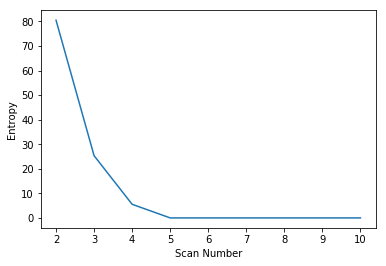

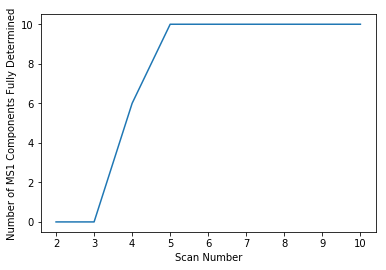

In [46]:
plt.figure(0)
plt.xlabel('Scan Number')
plt.ylabel('Entropy')
plt.plot(range(2,8+num_extra_bins), ent[0][2:],color='C0')

plt.figure(1)
plt.xlabel('Scan Number')
plt.ylabel('Number of MS1 Components Fully Determined')
plt.plot(range(2,8+num_extra_bins), ent[1][2:],color='C0')

In [48]:
test.mz_options

[array([71.08703785, 71.08703785, 71.08703785, 71.08703785, 71.08703785]), array([140.00449818, 140.00449818, 140.00449818, 140.00449818,
       140.00449818, 140.00449818, 140.00449818, 140.00449818]), array([110.88754535, 110.88754535, 110.88754535, 110.88754535]), array([167.06248634, 167.06248634, 167.06248634, 167.06248634,
       167.06248634]), array([91.53943443, 91.53943443, 91.53943443, 91.53943443]), array([64.09473516, 64.09473516, 64.09473516, 64.09473516]), array([56.52911953, 56.52911953, 56.52911953, 56.52911953, 56.52911953,
       56.52911953, 56.52911953]), [array([121.01620913])], array([53.92317619, 53.92317619]), array([55.77770004, 55.77770004, 55.77770004, 55.77770004, 55.77770004])]

# Create Noisy_Peak Class and Test

In [8]:
Data_test=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',1,1,ms2_mz_noise_sd=1,ms2_intensity_noise_sd=1)

In [9]:
# True ms2 mz Value
Data_test.peaks[1].mz

181.1160831470866

In [10]:
# Sampled ms2 mz Values
for i in range(0,10):
    print(Data_test.peaks[1].get(2,0,[(0,2000)])[0][0])

181.34111545920888
180.66500684420959
180.1334478916317
180.29908259422785
180.2667762293737
180.65755125730493
180.20304645686966
183.37499147622475
181.4206054682208
181.69833696380553


In [11]:
# True ms2 intensity Value
Data_test.peaks[1].intensity

433099.95014183933

In [12]:
# Sampled ms2 mz Values
for i in range(0,10):
    print(Data_test.peaks[1].get(2,0,[(0,2000)])[1][0])

433099.72738859244
433098.8172234633
433099.42718426563
433099.1294838124
433102.68658365303
433100.3859816186
433099.6635640976
433099.6388283146
433099.9811378458
433100.42901224305


In [135]:
Data_test=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',10,1,ms2_noise_sd=0.01)
num_extra_bins=3
test=Dia_Kaufmann(Data_test,64,"percentile","tree",extra_bins=num_extra_bins)

In [136]:
ent = test.entropy(2)

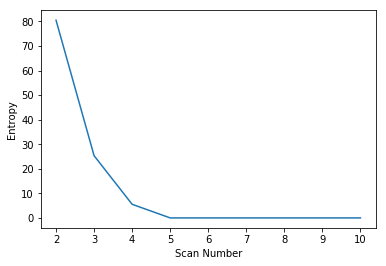

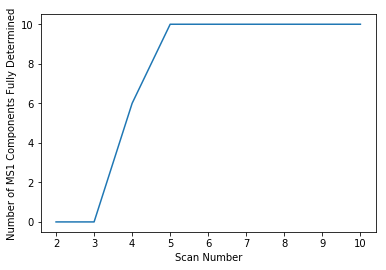

In [137]:
plt.figure(0)
plt.xlabel('Scan Number')
plt.ylabel('Entropy')
plt.plot(range(2,8+num_extra_bins), ent[0][2:],color='C0')

plt.figure(1)
plt.xlabel('Scan Number')
plt.ylabel('Number of MS1 Components Fully Determined')
plt.plot(range(2,8+num_extra_bins), ent[1][2:],color='C0')

In [140]:
test.mz_options[1]

array([106.16987176, 106.16362335, 106.15960807, 106.16116294])

# Create Datasets where MS1s can have the same MS2 Fragments

In [8]:
Data_test=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',5,5,ms2_noise_sd=0.01,alpha=0.1)

In [9]:
for i in range(0,len(Data_test.peaks)):
    if Data_test.peaks[i].ms_level==2:
        print(Data_test.peaks[i])
    if  Data_test.peaks[i].ms_level==1:
        print( ) 


Peak mz=52.4485 rt=0.00 intensity=6597.54 ms_level=2
Peak mz=105.5893 rt=0.00 intensity=9860.76 ms_level=2
Peak mz=88.3003 rt=0.00 intensity=10087.68 ms_level=2
Peak mz=129.4818 rt=0.00 intensity=8303.40 ms_level=2
Peak mz=69.9181 rt=0.00 intensity=2391.68 ms_level=2

Peak mz=60.2432 rt=0.00 intensity=972216.72 ms_level=2
Peak mz=88.3003 rt=0.00 intensity=10087.68 ms_level=2
Peak mz=105.5893 rt=0.00 intensity=9860.76 ms_level=2
Peak mz=129.4818 rt=0.00 intensity=8303.40 ms_level=2
Peak mz=52.4485 rt=0.00 intensity=6597.54 ms_level=2

Peak mz=52.7073 rt=0.00 intensity=67536.17 ms_level=2
Peak mz=52.4485 rt=0.00 intensity=6597.54 ms_level=2
Peak mz=88.3003 rt=0.00 intensity=10087.68 ms_level=2
Peak mz=105.5893 rt=0.00 intensity=9860.76 ms_level=2
Peak mz=129.4818 rt=0.00 intensity=8303.40 ms_level=2

Peak mz=73.0632 rt=0.00 intensity=4098.44 ms_level=2
Peak mz=52.4485 rt=0.00 intensity=6597.54 ms_level=2
Peak mz=69.9181 rt=0.00 intensity=2391.68 ms_level=2
Peak mz=129.4818 rt=0.00 inten

# Initial Simplification of Scanning Method

In [17]:
m = Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',5,1,ms2_mz_noise_sd=0,ms2_intensity_noise_sd=0)

In [18]:
DIA = Dia_Methods(m,2,0,"kaufmann","even","tree")

In [209]:
dia_results = DIA
ms2_mz_slack=0.00001
ms2_intensity_slack=0.1

In [210]:
scan_results = [[] for i in range(len(dia_results.locations))]
unlisted_mz_in_scans = np.concatenate(dia_results.mz_in_scans)
unlisted_intensities_in_scans = np.concatenate(dia_results.intensities_in_scans)

In [211]:
# find unique mz
unique_mz = [[unlisted_mz_in_scans[0]]]
unique_intensities = [[unlisted_intensities_in_scans[0]]]
for unlisted_mz_index in range(1,len(unlisted_mz_in_scans)):
    unique_mz_min = math.inf
    for unique_mz_index in range(len(unique_mz)):
        unique_dist = abs(sum(unique_mz[unique_mz_index])/len(unique_mz[unique_mz_index]) - unlisted_mz_in_scans[unlisted_mz_index])
        if(unique_dist < unique_mz_min):
            unique_mz_min = unique_dist
            unique_mz_which = unique_mz_index
    if unique_mz_min < ms2_mz_slack:
        unique_mz[unique_mz_which].append(unlisted_mz_in_scans[unlisted_mz_index])
        unique_intensities[unique_mz_which].append(unlisted_intensities_in_scans[unlisted_mz_index])
    else:
        unique_mz.append([unlisted_mz_in_scans[unlisted_mz_index]])
        unique_intensities.append([unlisted_intensities_in_scans[unlisted_mz_index]])

In [212]:
for unique_mz_index in [1]: #range(len(unique_mz)):
    if max(abs(unique_intensities[unique_mz_index] - sum(unique_intensities[unique_mz_index])/len(unique_intensities[unique_mz_index]))) > ms2_intensity_slack:
        print("hello")
    else:
        for location_index in range(len(dia_results.locations)):
            TF_in_location = []
            for unique_index in range(len(unique_mz[unique_mz_index])):
                TF_in_location.append(unique_mz[unique_mz_index][unique_index] in dia_results.mz_in_scans[location_index] and unique_intensities[unique_mz_index][unique_index] in dia_results.intensities_in_scans[location_index])
            if any(TF_in_location):
                scan_results[location_index].append(1)
            else:
                scan_results[location_index].append(0)

In [227]:
class Scan_Results_Calculator(object):
    def __init__(self,dia_results,ms2_mz_slack=0.00001,ms2_intensity_slack=0.1):
        self.intensities_in_scans = dia_results.intensities_in_scans
        self.mz_in_scans = dia_results.mz_in_scans
        self.locations = dia_results.locations
        self.bin_walls = dia_results.bin_walls
        self.ms1_values = dia_results.ms1_values
        self.results = [[] for i in range(len(dia_results.locations))]
        unlisted_mz_in_scans = np.concatenate(dia_results.mz_in_scans)
        unlisted_intensities_in_scans = np.concatenate(dia_results.intensities_in_scans)
        # find unique mz
        unique_mz = [[unlisted_mz_in_scans[0]]]
        unique_intensities = [[unlisted_intensities_in_scans[0]]]
        for unlisted_mz_index in range(1,len(unlisted_mz_in_scans)):
            unique_mz_min = math.inf
            for unique_mz_index in range(len(unique_mz)):
                unique_dist = abs(sum(unique_mz[unique_mz_index])/len(unique_mz[unique_mz_index]) - unlisted_mz_in_scans[unlisted_mz_index])
                if(unique_dist < unique_mz_min):
                    unique_mz_min = unique_dist
                    unique_mz_which = unique_mz_index
            if unique_mz_min < ms2_mz_slack:
                unique_mz[unique_mz_which].append(unlisted_mz_in_scans[unlisted_mz_index])
                unique_intensities[unique_mz_which].append(unlisted_intensities_in_scans[unlisted_mz_index])
            else:
                unique_mz.append([unlisted_mz_in_scans[unlisted_mz_index]])
                unique_intensities.append([unlisted_intensities_in_scans[unlisted_mz_index]])
        self.ms2_intensities = unique_intensities
        self.ms2_mz = unique_mz 
        # find where intensities are unique and assign them a scan result
        for unique_mz_index in range(len(unique_mz)):
            if max(abs(unique_intensities[0] - sum(unique_intensities[0])/len(unique_intensities[0]))) > ms2_intensity_slack:
                print("not ready yet")
            else:
                for location_index in range(len(dia_results.locations)):
                    TF_in_location = []
                    for unique_index in range(len(unique_mz[unique_mz_index])):
                        TF_in_location.append(unique_mz[unique_mz_index][unique_index] in dia_results.mz_in_scans[location_index] and unique_intensities[unique_mz_index][unique_index] in dia_results.intensities_in_scans[location_index])
                    if any(TF_in_location):
                        self.results[location_index].append(1)
                    else:
                        self.results[location_index].append(0)

# Testing

In [251]:
m = Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',ms2_mz_noise_sd=0,ms2_intensity_noise_sd=0)

In [254]:
DIA = Dia_Methods(m,2,0,"kaufmann","percentile","tree")

In [255]:
scan_results = Scan_Results_Calculator(DIA)
d = Dia_Location_Finder(scan_results)
e = Entropy(d)
print(e.entropy)
print(e.components_determined)
print(e.components)

405.1231782480885
0
160


Potentially add a wrapper to convert a DIA_results to a subsection of the DIA results -  to allow easy entropy plot calculations

add some measure of accuracy. At some point if we increase error enough we will get things wrong

# To Do List

To do list
    - Quatification of Error Introduced by Noise
        - Needs stress testing with large noise value
        - probably needs fixing so it works
    - Reorganise methods
    - Speed up methods so can be used in real time more easily